In [1]:
# Standard library imports
import subprocess
import sys
from pathlib import Path

from multiview_mapping_toolkit.utils.visualization import show_segmentation_labels
from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet

# Imports from the constants
sys.path.append("../..")
from constants import (
    MMSEG_PYTHON,
    MMSEG_UTILS_PYTHON,
    INFERENCE_SCRIPT,
    VIS_PREDS_SCRIPT,
    LABELS_FILENAME,
    get_inference_image_folder,
    get_work_dir,
    get_prediction_folder,
    get_images_near_labels_folder,
    get_image_folder,
    get_oblique_images_folder,
    get_camera_filename
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
TEST_SITE = "lassic"
TRAINING_SITES = sorted(["chips", "delta"])

BUFFER_RADIUS_METERS = 50

Loading GPS data for camera set: 100%|██████████| 19175/19175 [00:00<00:00, 2130202.07it/s]
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


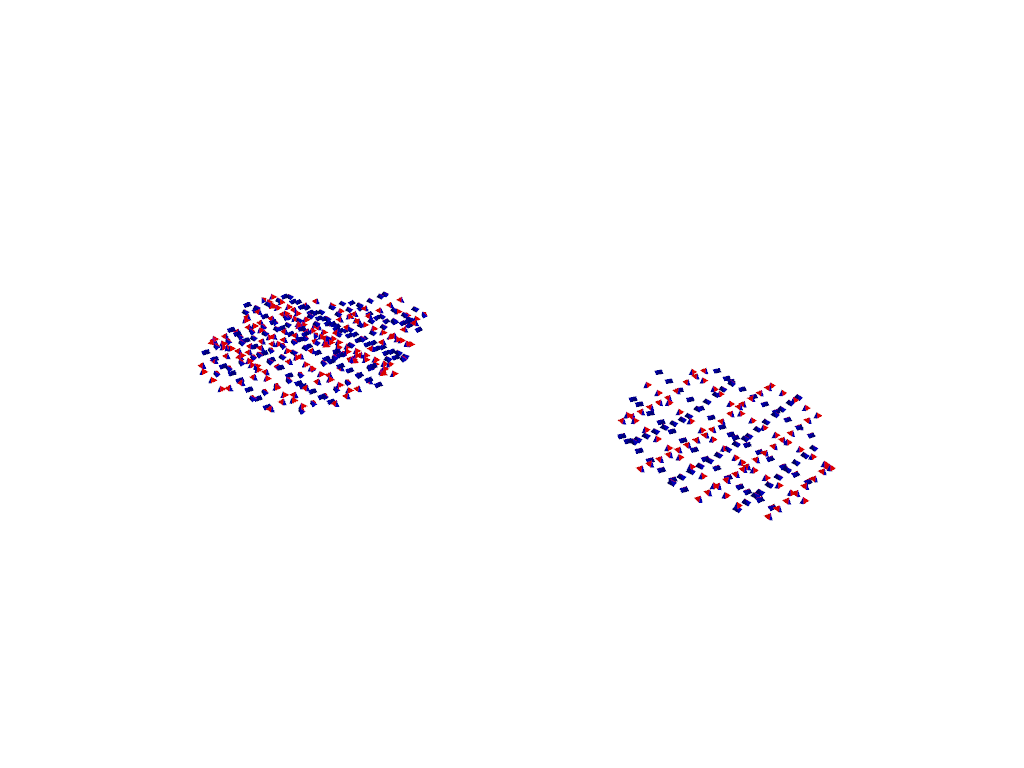

Saving subset of images near labels to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/03_training_data/images_near_labels
about to remove /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/03_training_data/images_near_labels


100%|██████████| 496/496 [00:03<00:00, 151.21it/s]


In [3]:
IMAGE_FOLDER = get_image_folder(TEST_SITE)
IMAGE_FOLDER_OBLIQUE = get_oblique_images_folder(TEST_SITE)
CAMERAS_FILENAME = get_camera_filename(TEST_SITE)

# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
training_camera_set = training_camera_set.get_cameras_in_folder(IMAGE_FOLDER_OBLIQUE)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)


IMAGES_NEAR_LABELS_FOLDER = get_images_near_labels_folder(TEST_SITE)

print(f"Saving subset of images near labels to {IMAGES_NEAR_LABELS_FOLDER}")
training_camera_set.save_images(IMAGES_NEAR_LABELS_FOLDER)

# Generate predictions with the model

In [4]:
WORK_DIR = get_work_dir(training_sites=TRAINING_SITES, is_ortho=False, is_scratch=False)
INFERENCE_IMAGE_FOLDER = get_inference_image_folder(site_name=TEST_SITE)
PREDICTIONS_FOLDER = get_prediction_folder(
    prediction_site=TEST_SITE, training_sites=TRAINING_SITES, is_ortho=False
)


config_file = list(Path(WORK_DIR).glob("*py"))[0]
checkpoint_file = Path(WORK_DIR, "iter_10000.pth")
BATCH_SIZE = 2

subprocess.run(
    f"{MMSEG_PYTHON} {INFERENCE_SCRIPT} {config_file} "
    + f"{checkpoint_file} {INFERENCE_IMAGE_FOLDER} {PREDICTIONS_FOLDER} --batch-size {BATCH_SIZE}",
    shell=True,
)

/ofo-share/repos-david/mmsegmentation/mmseg/models/builder.py:42: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn(
/ofo-share/repos-david/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:245: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/MVMT_chips_delta/work_dir/iter_10000.pth


CompletedProcess(args='/ofo-share/repos-david/conda/envs/openmmlab/bin/python /ofo-share/repos-david/mmsegmentation/tools/inference.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/MVMT_chips_delta/work_dir/MVMT_chips_delta.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/MVMT_chips_delta/work_dir/iter_10000.pth /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/03_training_data/images_near_labels /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/04_model_preds/chips_delta_MVMT_model --batch-size 2', returncode=0)

# Visualize predictions

In [5]:
# Add _vis to the folder name. Can't just add _vis to the str representation because it might have a trailing slash
pred_vis_dir = Path(
    Path(PREDICTIONS_FOLDER).parent, Path(PREDICTIONS_FOLDER).parts[-1] + "_vis"
)
STRIDE = 10

subprocess.run(
    f"{MMSEG_UTILS_PYTHON} {VIS_PREDS_SCRIPT} --image-dir {INFERENCE_IMAGE_FOLDER} "
    + f"--seg-dir {PREDICTIONS_FOLDER} --output-dir {pred_vis_dir} --stride {STRIDE}",
    shell=True,
)

visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/04_model_preds/chips_delta_MVMT_model_vis: 100%|██████████| 11/11 [00:37<00:00,  3.43s/it]


CompletedProcess(args='/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python /ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py --image-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/03_training_data/images_near_labels --seg-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/04_model_preds/chips_delta_MVMT_model --output-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/lassic/04_model_preds/chips_delta_MVMT_model_vis --stride 10', returncode=0)

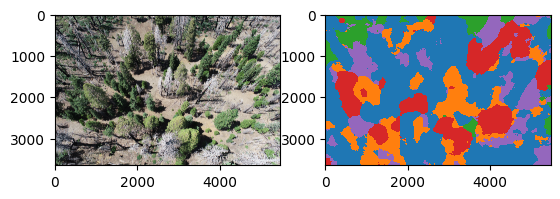

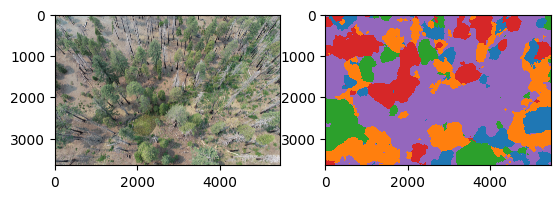

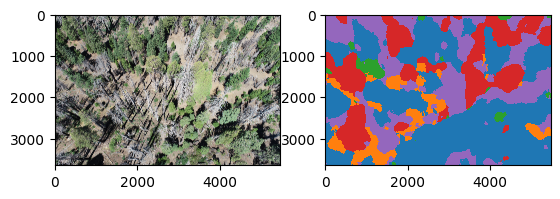

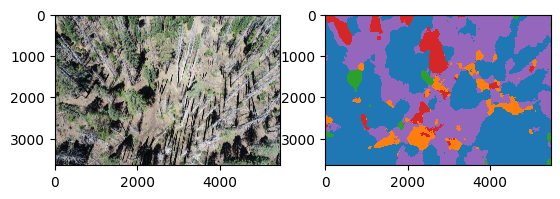

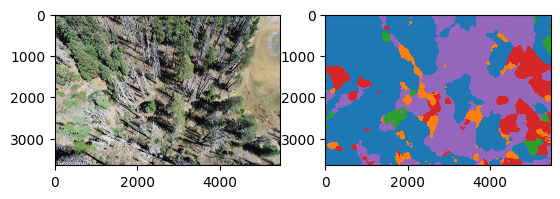

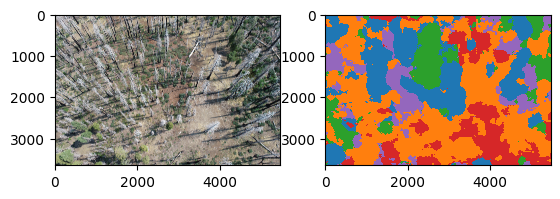

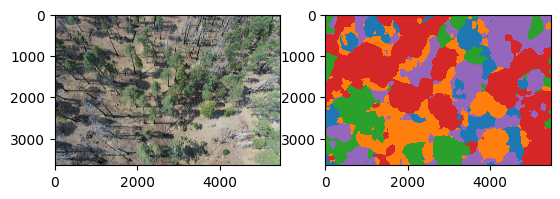

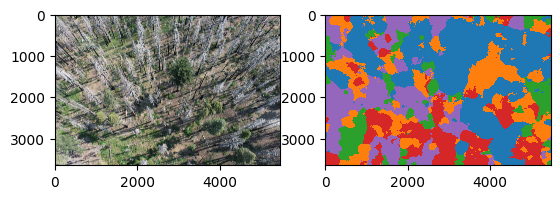

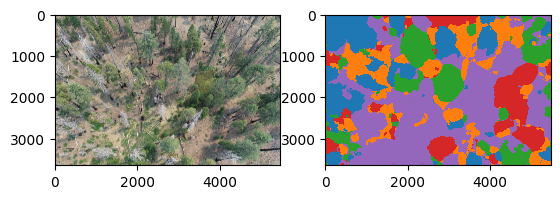

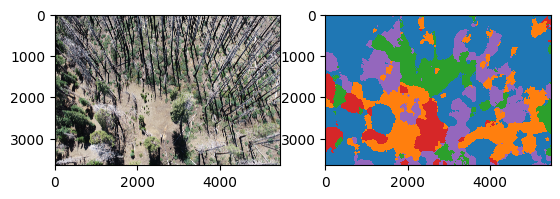

In [6]:
show_segmentation_labels(
    label_folder=PREDICTIONS_FOLDER, image_folder=INFERENCE_IMAGE_FOLDER
)